![](../../docs/gerics.png)
# GERICS Waldbroschüre 
## Program zum erstellen der Tabelle 1

Mit diesem Programm wurde die Tabelle 1 in der GERICS Waldbroschüre erstellt. 

**Katharina Bülow**, Climate Service Center Germany (GERICS), Helmholtz-Zentrum hereon GmbH, Email: katharina.buelow@hereon.de

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
from glob import glob

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colormaps
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

Um die Tabelle zu erstellen, benötigt man 2 gleiche *DataFrames*, einen mit den Daten und einen mit der Information zur Robustheit.

In [2]:
# Organization der Verzeichnisse und Dateien

workdir = os.getcwd()

plotdir = "plots_of_table"
outdir = os.path.join(workdir, plotdir)
if not os.path.exists(outdir):
    os.makedirs(outdir)

datadir=workdir.split('Notebooks')[0]
# CORDEX
cordex = "input_data/cordex"
indir = os.path.join(datadir, cordex)
# EOBS
obs = "input_data/eobs"
indirObs = os.path.join(datadir, obs)
indirObs

'/work/ch0636/g300047/GITHUB/climate-action-sheet-forestry/input_data/eobs'

In [3]:
# Es wird nur RCP8.5 verwendet

# Auswahl der Region:
region = "08212_08215_07334_Region_um_Karlsruhe"
ort = "Karlsruhe"
method = "absolute"

# Hier kann auswählen ob man Min/Max oder Percentile bzw Mean oder Median verwenden möchte

if method == "pro":
    fix = "rcp85_time-mean_ensemble-diff-frac-median"
    fixm = "rcp85_time-mean_ensemble-diff-frac-min-max"
    fixr = "rcp85_ensemble-robustness"
else:
    fix = "rcp85_time-mean_ensemble-diff-median"
    fixm = "rcp85_time-mean_ensemble-diff-min-max"
    fixr = "rcp85_ensemble-robustness"

frequency = "year"
index_season = ["TG", "RRm", "DD", "FG"]

# Farben für die Robustheit festlegen:
# grau:
cmap_dict = {0: "#f7f7f7", 1: "#cccccc", 2: "#969696", 3: "#636363"}

# Indizes: Frost, Spätfrost, Niederschlag, Wind, Hitze, Hitzeperiode und Trockenheit
index = [
    "FD",
    "LFD",
    "RRm",
    "SU30",
    "SU35",
    "HSx3",
    "HSf3",
    "DD",
    "DSx5",
    "DSf",
]

plotname = "Karlsruhe_table_GWL_" + region + "_median_grey_300.png"
figure = os.path.join(outdir, plotname)

In [4]:
def rename(df, ind, frequency, fix, fixm, fixr):
    # Umbenennen der Spalten des DataFrame
    # das wird der Name der in der Tabelle später zusehen ist

    df_ = df.copy()
    return df_.rename(
        columns={
            "ci_name": "Index",
            ind + "_" + frequency + "_ref_time-mean": "1971-2000",
            "dummy": "1971-2000",
            ind + "_" + frequency + "_1.5C_" + fix: "Änderung 1.5 °C",
            ind + "_" + frequency + "_2C_" + fix: "Änderung 2 °C",
            ind + "_" + frequency + "_3C_" + fix: "Änderung 3 °C",
            ind + "_" + frequency + "_4C_" + fix: "Änderung 4 °C",
            ind + "_" + frequency + "_1.5C_" + fixr: "Änderung 1.5 °C",
            ind + "_" + frequency + "_2C_" + fixr: "Änderung 2 °C",
            ind + "_" + frequency + "_3C_" + fixr: "Änderung 3 °C",
            ind + "_" + frequency + "_4C_" + fixr: "Änderung 4 °C",
            ind + "_" + frequency + "_1.5C_" + fixm: "Änderung 1.5 °C",
            ind + "_" + frequency + "_2C_" + fixm: "Änderung 2 °C",
            ind + "_" + frequency + "_3C_" + fixm: "Änderung 3 °C",
            ind + "_" + frequency + "_4C_" + fixm: "Änderung 4 °C",
        }
    )

In [5]:
def rename_index(df):
    # Umbenennen des Index
    df_ = df.copy()
    return df_.rename(
        index={
            "TG": "Temperatur [°C]",
            "TG1": "Winter [°C]",
            "TG4": "Frühjahr [°C]",
            "TG7": "Sommer [°C]",
            "TG10": "Herbst [°C]",
            "SU": "Sommertage [Tage]",
            "SU30": "Hitzetage (Tmax > 30°C) [Tage]",
            "SU35": "Temperaturmax. > 35°C [Tage]",
            "SU40": "Temperaturmax. > 40°C [Tage]",
            "FD": "Frosttage [Tage]",
            "LFD": "Spätfrosttage [Tage]",
            "HSx3": "max. Hitzewelle [Tage]",
            "HSf3": "Hitzewellen [Anzahl]",
            "RRm": "jährl. Niederschlag [mm/Tag]",
            "RRm1": "Winterniederschlag [mm/Tag]",
            "RRm4": "Frühlingsniederschlag [mm/Tag]",
            "RRm7": "Sommerniederschlag [mm/Tag]",
            "RRm10": "Herbstniederschlag [mm/Tag]",
            "DD1": "Trockentage im Winter [Tage]",
            "DD4": "Trockentage im Frühjahr [Tage]",
            "DD7": "Trockentage im Sommer [Tage]",
            "DD10": "Trockentage im Herbst [Tage]",
            "DD": "Trockentage im Jahr [Tage]",
            "DSx5": "jährl. max.Trockenperiode [Tage]",
            "DSf": "jährl. Trockenperioden [Anzahl]",
            "FG": "Windgeschwindigkeit [m/s]",
            "FG1": "Winter [m/s]",
            "FG4": "Frühjahr [m/s]",
            "FG7": "Sommer [m/s]",
            "FG10": "Herbst [m/s]",
        }
    )

In [6]:
def minmax(files, region, s, method):
    # Einlesen der Minimum und Maximum Dateien
    # Sie werden in eine Spalte gequetscht, damit sie später in der Tabelle unter dem Median zusehen sind.

    # Die Beobachtungen haben kein Minimum und Maximum, da es nur 1 Datenfile gibt.
    dft = pd.DataFrame(["Min:Max"], columns=["ci_name"])
    dfd = pd.DataFrame(np.nan, index=[0], columns=["dummy"])
    dft = pd.concat([dft, dfd], axis=1)

    for i in files:
        if method == "pro":
            minfile = i.replace("diff-frac-median", "diff-frac-min")
            maxfile = i.replace("diff-frac-median", "diff-frac-max")
        else:
            minfile = i.replace("diff-median", "diff-min")
            maxfile = i.replace("diff-median", "diff-max")

        dfmin = pd.read_csv(minfile)
        dfmax = pd.read_csv(maxfile)

        seln_ = select_region(dfmin, region)
        selx_ = select_region(dfmax, region)
        seln = seln_.loc[(seln_["mid_month"].isin([s]))]
        selx = selx_.loc[(selx_["mid_month"].isin([s]))]

        cmin = col_name(minfile)
        cmax = col_name(maxfile)

        if method == "pro":
            endcmax = cmax.split("-")[4]
            t = seln[cmin]
            val_cmin = t * 100
            tm = selx[cmax]
            val_cmax = tm * 100
            dfn = val_cmin.map("{:,.1f}".format)
            dfm = val_cmax.map("{:,.1f}".format)
        else:
            endcmax = cmax.split("-")[3]
            dfn = seln[cmin].map("{:,.1f}".format)
            dfm = selx[cmax].map("{:,.1f}".format)

        dfn_ = dfn.reset_index(drop=True)
        dfm_ = dfm.reset_index(drop=True)
        dft_ = pd.concat([dft, dfn_, dfm_], axis=1)
        dft__ = dft_.replace("0.0", "0")
        dft = dft__.replace("-0.0", "0")
        dft[cmin + "-" + endcmax] = dft[cmin] + " : " + dft[cmax]
        dft.drop([cmin, cmax], inplace=True, axis=1)

    return dft

In [7]:
def select_region(df, region):
    return df.loc[(df["region"].isin([region]))]

In [8]:
def col_name(i):
    # Name der Spalte
    t = i.split("/")[-1]
    c = t.split(".cs")[0]
    return c

In [9]:
def col_eobs_name(i):
    # Name der Spalte
    t = i.split("/")[-1]
    c = t.split(".cs")[0]
    return c

In [10]:
def read_eobs(i, ind, frequency, saison):
    """Einlesen der saisonalen Referenzedaten für 1971-2000"""

    dft = pd.DataFrame()
    df = pd.read_csv(i)
    sel = select_region(df, region)
    c = col_eobs_name(i)
    if ind == "TG":
        sel[c] = sel[c] - 273.15

    if saison == 12:
        dft["Index"] = sel["ci_name"]
        dfl = sel[c].map("{:,.1f}".format)

    else:
        sel_ = sel.loc[(sel["mid_month"].isin([saison]))]
        dfl = sel_[c].map("{:,.1f}".format)
        dft["Index"] = sel_["ci_name"].str.cat(sel_["mid_month"].values.astype(str))

    dft = pd.concat([dft, dfl], axis=1)
    return dft

In [11]:
def gwl(files, region, dft, s):
    # Es ist wichtig die Spalten hier klar zubenennen, sonst passiert ein Fehler.
    for gwl in ("_1.5C_", "_2C_", "_3C_", "_4C_"):
        dfile = sorted([dfile for dfile in files if gwl in dfile])
        i = dfile[0]
        df = pd.read_csv(i)
        sel_ = select_region(df, region)
        c = col_name(i)
        sel = sel_.loc[(sel_["mid_month"].isin([s]))]
        if "diff-frac-" in c:
            t = sel[c]
            val = t * 100
            dfl = val.map("{:,.1f} %".format)
        else:
            dfl = sel[c].map("{:,.1f}".format)
        dft.reset_index(drop=True, inplace=True)
        dfl.reset_index(drop=True, inplace=True)
        # unclear wird ersetzt: 0 mit 0.5
        if "ensemble-robustness" in c:
            dfl = dfl.replace("0.0", "0.5")
        dft = pd.concat([dft, dfl], axis=1)
    return dft

In [12]:
def gwlmm(files):  # ,s)#,region,dft,s):
    # Es ist wichtig die Spalten hier klar zubenennen, sonst passiert ein Fehler.
    for gwl in ("_1.5C_", "_2C_", "_3C_", "_4C_"):
        dfile = sorted([dfile for dfile in files if gwl in dfile])
        i = dfile[0]
        c = col_name(i)

        dfmm[c] = 0
    return dfmm

In [13]:
def obs_robust(ind_, i):
    # Beobachtungen haben eine Robustheit
    if i == 12:
        ind = ind_
    else:
        ind = ind_ + str(i)
    dft = pd.DataFrame([ind], columns=["ci_name"])
    dfd = pd.DataFrame(0, index=[0], columns=["dummy"])
    dft = pd.concat([dft, dfd], axis=1)

    # Für Robustheit bleibt Min:Max nan
    dfmm = pd.DataFrame(["Min : Max"], columns=["ci_name"])
    dfm = pd.DataFrame(np.nan, index=[0], columns=["dummy"])
    dfmm = pd.concat([dfmm, dfm], axis=1)
    return dft, dfmm

In [14]:
df_out = pd.DataFrame()

for ind in index:
    # Jährlich
    # Einlesen der Beobachtungen in der 1. Spalte
    fileo = (
        indirObs
        + "/"
        + frequency
        + "/"
        + ind
        + "/"
        + ind
        + "_"
        + frequency
        + "_ref_time-mean.csv"
    )
    dft = read_eobs(fileo, ind, frequency, 12)
    # Einlesen von euro-cordex
    files = glob(
        indir
        + "/"
        + frequency
        + "/"
        + ind
        + "/"
        + ind
        + "_"
        + frequency
        + "*"
        + fix
        + ".csv"
    )
    dfmm = minmax(files, region, 7, method)
    dfmm_ = rename(dfmm, ind, frequency, fix, fixm, fixr)
    dft = gwl(files, region, dft, 7)
    dft_ = rename(dft, ind, frequency, fix, fixm, fixr)

    # Hier werden alle unter einander geschrieben:
    df_out = pd.concat([df_out, dft_, dfmm_], axis=0)

    # season:
    if ind in index_season:
        fileo = (
            indirObs
            + "/"
            + "sem"
            + "/"
            + ind
            + "/"
            + ind
            + "_"
            + "sem"
            + "_ref_time-mean.csv"
        )
        for i in [4, 7]:
            dft = read_eobs(fileo, ind, frequency, i)
            files = glob(
                indir + "/sem/" + ind + "/" + ind + "_sem_" + "*" + fix + ".csv"
            )
            dfmm = minmax(files, region, i, method)
            dfmm_ = rename(dfmm, ind, "sem", fix, fixm, fixr)
            dft = gwl(files, region, dft, i)
            dft_ = rename(dft, ind, "sem", fix, fixm, fixr)
            # Hier wird alles untereinander geschrieben
            df_out = pd.concat([df_out, dft_, dfmm_], axis=0)

# Index setzen
df_out_ = df_out.copy()
df_index_ = df_out_.set_index(["Index"])
df_index__ = df_index_.replace("-0.0", "0")
df_index = df_index__.replace("0.0", "0")

Nun benötigen wir genau denselben Dataframe, um die Robustheit in Farbe darzustellen. Min/Max
haben keine Robustheit und werden in Hellgrau hervorgehoben. Min/Max wurde für die Beobachtungen nicht berechnet: daher leer und weiß, sodass die Robustheit hier auf NaN gesetzt werden muss.

In [15]:
df_r = pd.DataFrame()

for ind in index:
    # Beobachtung hat keine Robustheit
    dft, dfmm = obs_robust(ind, 12)
    # euro-cordex:
    files = glob(
        indir
        + "/"
        + frequency
        + "/"
        + ind
        + "/"
        + ind
        + "_"
        + frequency
        + "*"
        + fixr
        + ".csv"
    )
    dft = gwl(files, region, dft, 7)
    dfmm = gwlmm(files)

    dft_ = rename(dft, ind, frequency, fix, fixm, fixr)
    dfmm_ = rename(dfmm, ind, frequency, fix, fixm, fixr)

    # here everything will be written below each other
    df_r = pd.concat([df_r, dft_, dfmm_], axis=0)
    # season
    if ind in index_season:
        for i in [4, 7]:
            dft, dfmm = obs_robust(ind, i)
            files = glob(
                indir + "/sem/" + ind + "/" + ind + "_sem_" + "*" + fixr + ".csv"
            )
            dft = gwl(files, region, dft, i)
            dfmm = gwlmm(files)
            dfmm_ = rename(dfmm, ind, "sem", fix, fixm, fixr)
            dft_ = rename(dft, ind, "sem", fix, fixm, fixr)
            # Here we write everything below each other:
            df_r = pd.concat([df_r, dft_, dfmm_], axis=0)

# set index
dfr = df_r.copy()
df_rob = dfr.set_index(["Index"])
df_rob

,1971-2000,Änderung 1.5 °C,Änderung 2 °C,Änderung 3 °C,Änderung 4 °C
Index,,,,,
FD,0.0,-2.0,-2.0,-2.0,-2.0
Min : Max,NaN,0,0,0,0
LFD,0.0,-2.0,-2.0,-2.0,-2.0
Min : Max,NaN,0,0,0,0
RRm,0.0,1.0,1.0,1.0,1.0
Min : Max,NaN,0,0,0,0
RRm4,0.0,1.0,1.0,1.0,1.0
Min : Max,NaN,0,0,0,0
RRm7,0.0,nan,nan,nan,-1.0


#### Bedeutung der Zahlen für die Robustheit:

* Threshold für Änderung=2/3
* Threshold für Signifikanz=0.5

**2** robust 2/3 in eine Richtung und 0.5 Signifikant

**1** trend 2/3 in einen Richtung

**0** unklar +/- aber 0.5 sind significant

**NaN** no change weniger als 2/3 und weniger als 1/2 signifikant




0 wird später für NaN benötigt.
E-OBS (Beobachtungen) und Min/Max haben keine Robustheit, daher werden sie auf NaN gesetzt.
Allerdings, wenn NaN in der Heatmap ist, fehlt der Wert ebenfalls, dies ist Absichtlich für E-OBS.
Für Min/MAX wird deshalb das NaN durch 0 ersetzt.
NaN wurde eingelesen.

In [16]:
df_robn_ = df_rob.replace("nan", 0)

## jetzt plotten:


In [18]:
# Die Robustheitsparameter werden einmal überschrieben,
# weil die Arbeit mit der Farbskala bei einheitlichen Abständen einfacher ist.
# Kein wissenschaftlicher Grund, nur um das Farbdesign zu vereinfachen.
# NaN in Weiß.

df_rob_ = df_robn_.replace(
    {
        "-2.0": "3",
        "-1.0": "2",
        "-0.5": "1",
        0: "0",
        "0.0": "0",
        "0.5": "1",
        "1.0": "2",
        "2.0": "3",
    }
)

for i in df_rob_.columns:
    df_rob_[i] = df_rob_[i].astype(float)

In [19]:
df_rob_ = rename_index(df_rob_)


In [20]:
df_index = rename_index(df_index)

In [22]:
# Die Tabelle klarer gestalten:
def add_plus(value):
    float_value = float(value)
    if float_value > 0:
        return "+" + str(float_value)
    else:
        return value

In [24]:
# Design:
# Schrift größe bestimmen

def annotate_row(row_index):
    if row_index == "Min:Max":
        return [8, 8, 8, 8, 8]  # Font sizes for each column in row
    else:
        return [12, 12, 12, 12, 12]  # Default font sizes


def annotate_row_weight(row_index):
    if row_index == "Min:Max":
        return ["light", "light", "light", "light", "light"]
    else:
        return [
            "bold",
            "bold",
            "bold",
            "bold",
            "bold",
        ]  


def label_color(label):
    if label == "Hitzetage (Tmax > 30°C) [Tage]":
        return "#dcab4c"
    if label == "Temperaturmax. > 35°C [Tage]":
        return "#dcab4c"
    if label == "max. Hitzewelle [Tage]":
        return "#cf6752"
    if label == "Hitzewellen [Anzahl]":
        return "#cf6752"
    if label == "Frosttage [Tage]":
        return "#97b0ca"
    if label == "Spätfrosttage [Tage]":
        return "#97b0ca"
    if label == "jährl. Niederschlag [mm/Tag]":
        return "#615793"
    if label == "Frühlingsniederschlag [mm/Tag]":
        return "#615793"
    if label == "Sommerniederschlag [mm/Tag]":
        return "#615793"
    if label == "Trockentage im Jahr [Tage]":
        return "#882a4f"
    if label == "Trockentage im Frühjahr [Tage]":
        return "#882a4f"
    if label == "Trockentage im Sommer [Tage]":
        return "#882a4f"
    if label == "jährl. max.Trockenperiode [Tage]":
        return "#882a4f"
    if label == "jährl. Trockenperioden [Anzahl]":
        return "#882a4f"
    else:
        return "k"

Plot saved:  /work/ch0636/g300047/GITHUB/climate-action-sheet-forestry/Notebooks/INDICES-TABLE/plots_of_table/Karlsruhe_table_GWL_08212_08215_07334_Region_um_Karlsruhe_median_grey_300.png


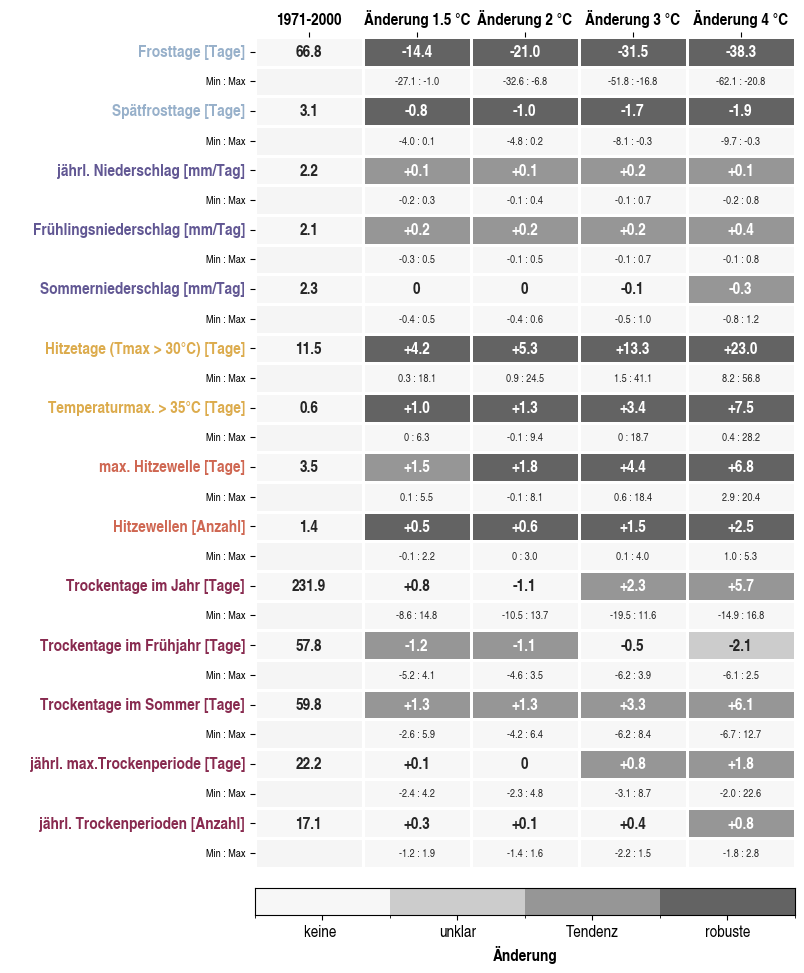

In [26]:
# Plotten:
# komischerweise muss ich dies 2 mal ausführen um auch die Schrift zubekommen, die ich will.
plt.rcParams["font.family"] = "Nimbus Sans Narrow"

colorrange = range(len(list(cmap_dict.keys())))
cmap = ListedColormap([cmap_dict[i] for i in [0, 1, 2, 3]])
bounds = np.array(range(len(list(cmap_dict.keys())) + 1)) - 0.5

# Um genau eine Farbbox pro ganzzahligem Interval zu erhalten:

norm = mpl.colors.BoundaryNorm(bounds, len(colorrange))

# annot ist df_ der Wert des Indices, die farbe ist die robustheit dfr_
size = (8, 13)
fig, ax = plt.subplots(figsize=size)
# plt.rcParams['font.family'] = 'Nimbus Sans Narrow'
fig.subplots_adjust(right=0.8)

ax = sns.heatmap(
    df_rob_,
    annot=df_index,
    fmt="",
    cmap=cmap,
    norm=norm,
    cbar_kws={
        "orientation": "horizontal",
        "pad": 0.02,
        "label": "Änderung",
    },
    linewidths=1,
)
ax.set_facecolor("whitesmoke")
ax.figure.axes[-1].xaxis.label.set_size(12)  # größe der Schrift der colorbar legende
ax.figure.axes[-1].xaxis.label.set_fontweight("bold")


for label in ax.get_yticklabels():
    lc = label_color(label.get_text())
    label.set_color(lc)
    if label.get_text() != "Min : Max":
        label.set_weight("bold")
        label.set_size(12)
    else:
        label.set_size(8)


# Das ist ein Workaround, da 'Min-Max' in der ersten Spalte ein NaN hat und ich es nicht entfernen konnte.

m = 0
for i in range(len(df_index)):
    font_sizes = annotate_row(df_index.index[i])
    font_weight = annotate_row_weight(df_index.index[i])

    if i % 2 == 1:
        end = 4
    else:
        end = 5
        for k in range(1, end):
            df_index.iat[i, k] = add_plus(df_index.iat[i, k])

    for j in range(end):
        ax.texts[m].set_fontsize(font_sizes[j])
        ax.texts[m].set_fontweight(font_weight[j])
        # This would be nice, but does not work with naN
        # ax.texts[i * len(df_index.columns) + j].set_fontsize(font_sizes[j])
        m = m + 1

# Colorbar manipulieren:
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])

# Hier nochmal gucken was man hinneinschreiben möchte
c_bar.set_ticklabels(
    ["keine ", "unklar", "Tendenz", "robuste"],
    fontsize=12,
)
ax.xaxis.tick_top()  # x axis on top
ax.xaxis.set_label_position("top")
ax.set_ylabel(" ")
# ax.set_title(ort, color="k", fontsize=18)
plt.yticks(rotation=0)  # , fontsize=12)
plt.xticks(rotation=0, fontsize=12, fontweight="bold")

# spine draws the box around the colorbar
for spine in ax.collections[0].colorbar.ax.spines.values():
    spine.set_visible(True)  # show the border of the colorbar

# save plot:
plt.savefig(figure, dpi=300, bbox_inches="tight")
print("Plot saved: ", figure)